# SMARDcast: Day-Ahead Forecasting of German Electricity Consumption with Deep Learning

### Nick Krüger, Kolja Eger, Wolfgang Renz

E-Mail: {nick.krueger, kolja.eger, wolfgang.renz}@haw-hamburg.de

### Published in: International Conference on Smart Energy System and Technologies (SEST) 2024

URL: https://ieeexplore.ieee.org/document/10694018

This notebook contains a practical example of the work published in the publication "SMARDcast: Day-Ahead Forecasting of German Electricity Consumption with Deep Learning". The aim of this work was to showcase the application of deep neural networks for day-ahead forecasting of electricity consumption in Germany, using the power consumption data sets published on the SMARD plattform.

## Libraries

The following libraries are used to run this notebook. The repository also includes a requirements file of all used libraries.

In [1]:
import numpy as np
import pandas as pd
import datetime
import itertools

import tensorflow as tf
import keras

tf.keras.mixed_precision.set_global_policy('mixed_float16')
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

from deutschland import feiertage
from deutschland.feiertage.api import default_api
configuration = feiertage.Configuration(
    host = "https://feiertage-api.de/api"
)


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import TwoSlopeNorm

2024-11-25 15:56:43.766666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732546603.781655 3202905 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732546603.786287 3202905 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 15:56:43.802061: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Reading Data

For this experiment, we use the German electricity market data published by the German regulator on the SMARD platform. The individual .csv files contain a year of German power consumption data.

In [2]:
df_SMARD = pd.DataFrame()

url="https://raw.githubusercontent.com/koljaeger/smardcast/main/data/Realisierter_Stromverbrauch_"

for year in range(2015, 2023+1, 1):
    df_SMARD = pd.concat([df_SMARD, pd.read_csv(url+str(year)+"01010000_"+str(year)+"12312359_Viertelstunde.csv", 
                                    delimiter=";", thousands='.', decimal=",", dtype={"Datum":str})], axis=0, ignore_index=True)

df_SMARD["Date"] = pd.to_datetime(df_SMARD.pop("Datum")+' '+df_SMARD.pop("Anfang"), format="%d.%m.%Y %H:%M")
df_SMARD["Date"] = df_SMARD["Date"].dt.tz_localize("Europe/Berlin", ambiguous='infer').dt.tz_convert('UTC')

df_SMARD = df_SMARD.rename(
    columns={
        'Gesamt (Netzlast) [MWh] Originalauflösungen': 'Total Load [MWh]',
        'Residuallast [MWh] Originalauflösungen': 'Residual Load [MWh]',
        'Pumpspeicher [MWh] Originalauflösungen' : 'Energy from Pumped Storage [MWh]'
        }
    )

df_SMARD = df_SMARD.drop(columns=["Ende",'Residual Load [MWh]', 'Energy from Pumped Storage [MWh]'])

print(df_SMARD)

        Total Load [MWh]                      Date
0               11210.00 2014-12-31 23:00:00+00:00
1               11118.75 2014-12-31 23:15:00+00:00
2               11144.75 2014-12-31 23:30:00+00:00
3               11126.75 2014-12-31 23:45:00+00:00
4               11009.50 2015-01-01 00:00:00+00:00
...                  ...                       ...
315547          10564.00 2023-12-31 21:45:00+00:00
315548          10526.50 2023-12-31 22:00:00+00:00
315549          10443.75 2023-12-31 22:15:00+00:00
315550          10354.00 2023-12-31 22:30:00+00:00
315551          10147.50 2023-12-31 22:45:00+00:00

[315552 rows x 2 columns]


## Adding Time Features

To aid the model in understanding the seasonality of the SMARD power consumption dataset, we add additional input features. These use the timestamps of the dataset to generate sin and cosine values with the period of 1 hour, 1 day, 1 week, 1 month and 1 year for each timestep in the data set. We also add a categorical feature indicating the day of the week.

In [3]:
def add_time_features(df):
    new_columns = [(column, "") for column in df.columns]
      
    new_df = df
    new_df.columns=pd.MultiIndex.from_tuples(new_columns)

    times_dict = {"Hour Func" : (60*60), "Day Func" : (24*60*60), "Week Func" : (7*24*60*60), "Month Func" : (365.2425*24*60*60/12), "Year Func" : (365.2425*24*60*60)}

    num_of_seconds = (df["Date"].dt.tz_localize(None) - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")

    for column in times_dict:
        time_func_df = pd.DataFrame({"Sin" : np.sin(num_of_seconds * (2 * np.pi / times_dict[column])), "Cos" : np.cos(num_of_seconds * (2 * np.pi / times_dict[column]))})
        time_func_columns = [(column,"Sin"), (column,"Cos")]
        time_func_df.columns = pd.MultiIndex.from_tuples(time_func_columns)
    
        new_df = pd.concat([new_df,time_func_df], axis=1)

    new_df["Day of the Week"] = df["Date"].dt.dayofweek

    print("Time Step Sine Functions and Categories Added!")
    return new_df

In [4]:
df_SMARD = add_time_features(df_SMARD)

Time Step Sine Functions and Categories Added!


## Adding Holiday Features

In addition, we also add an additional feature to model public holidays. For this purpose, we use an api call to get the german public holidays for each year of the dataset. Public holidays in the data set are modeled as 1, days before public holidays as 0.5 and other days as 0.

In [5]:
def add_holiday_features(df):
    lowest_year = df["Date"].dt.year.min()
    highest_year = df["Date"].dt.year.max()

    holiday_dates = []

    with feiertage.ApiClient(configuration) as api_client:
        api_instance = default_api.DefaultApi(api_client)

    for jahr in range(lowest_year, highest_year+1):
        try:
            api_response = api_instance.get_feiertage(jahr=str(jahr), nur_land="HH", nur_daten=1)
        except feiertage.ApiException as e:
            print("Exception when calling DefaultApi->get_feiertage: %s\n" % e)

        for feiertag in api_response:
            holiday_dates.append(api_response[feiertag])

    df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d %H:%M:%S')
    df_days = df["Date"].dt.date

    days_before_holidays = {date - datetime.timedelta(days=1) for date in holiday_dates}

    df['Is Holiday'] = df_days.apply(lambda x: 1 if x in holiday_dates else (0.5 if x in days_before_holidays else 0))
    return df

In [6]:
df_SMARD = add_holiday_features(df_SMARD)

## Splitting the Data Set

The data set is then split into training, validation and testing data sets. In this example, we use the years 2015 - 2020 as training data, the years 2021 - 2022 as validation data and 2023 as testing data.

In [7]:
def split_df(df, train_start_date, train_stop_date, val_start_date, val_stop_date, test_start_date, test_stop_date):
    train_df = df[(df["Date"] >= train_start_date)]
    train_df = train_df[(train_df["Date"] <= train_stop_date)]

    val_df = df[(df["Date"] >= val_start_date)]
    val_df = val_df[(val_df["Date"] <= val_stop_date)]

    test_df = df[(df["Date"] >= test_start_date)]
    test_df = test_df[(test_df["Date"] <= test_stop_date)]

    return train_df, val_df, test_df

In [8]:
train_df, val_df, test_df = split_df(df_SMARD, train_start_date="2015-01-01 00:00", train_stop_date="2020-12-31 23:45",
                                     val_start_date="2021-01-01 00:00", val_stop_date="2022-12-31 23:45", 
                                     test_start_date="2023-01-01 00:00", test_stop_date="2023-12-31 23:45")

## Data Standardization

Before the data sets are used for training, they are standardized using mean-std-standardization. The mean and std values are calculated using only the training data set.

In [9]:
def standardize_data(train_df, val_df, test_df):

    train_date = train_df.pop("Date")
        
    mean = train_df.mean()
    std = train_df.std()

    std_train_df = (train_df - mean) / std
    std_train_df["Date"] = train_date

    val_date = val_df.pop("Date")
    std_val_df = (val_df - mean) / std
    std_val_df["Date"] = val_date

    test_date = test_df.pop("Date")
    std_test_df = (test_df - mean) / std
    std_test_df["Date"] = test_date

    print("Mean of training dataset:\n" + str(mean) + "\n")
    print("Standard deviation of training dataset:\n" + str(std))
    
    return std_train_df, std_val_df, std_test_df, mean, std

In [10]:
def inv_standardize_data(df, columns, mean, std):
    return df*float(std.loc[columns].iloc[0]) + float(mean.loc[columns].iloc[0])

In [11]:
train_df, val_df, test_df, mean, std = standardize_data(train_df, val_df, test_df)

Mean of training dataset:
Total Load [MWh]         1.425977e+04
Hour Func         Sin   -6.225513e-15
                  Cos   -4.128895e-16
Day Func          Sin   -3.710738e-15
                  Cos   -1.569574e-15
Week Func         Sin    1.895023e-04
                  Cos    3.982578e-04
Month Func        Sin    1.818410e-05
                  Cos    2.478341e-04
Year Func         Sin    1.517482e-06
                  Cos    2.486258e-04
Day of the Week          3.000000e+00
Is Holiday               7.664234e-02
dtype: float64

Standard deviation of training dataset:
Total Load [MWh]         2533.980755
Hour Func         Sin       0.707108
                  Cos       0.707108
Day Func          Sin       0.707108
                  Cos       0.707108
Week Func         Sin       0.707020
                  Cos       0.707197
Month Func        Sin       0.707022
                  Cos       0.707195
Year Func         Sin       0.707021
                  Cos       0.707196
Day of the Week  

## Data Windowing

In order to create the indiviual input and output sets for each training, validation and testing step, the data sets are windowed. In this case, the last input of each input window is at 9:45 am the day before the forecasted day, while the output window is an entire day. The input window in this example contains 672 timesteps, which contains one week worth of timesteps. These windows are created for every day of the training, validaytion and testing data sets.

In [12]:
def window_df(df, input_columns, label_columns, input_timesteps, label_timesteps, offset, window_split):

    df = df.reset_index(drop=True)
        
    timestep_index = []
    for i in range(0, len(df), window_split):
        if i > (input_timesteps + offset) and (len(df) - i) >= (label_timesteps):
            timestep_index.append(i)
    
    input_df = df[input_columns]
    label_df = df[label_columns]

    inputs = np.empty((len(timestep_index), input_timesteps, len(input_df.columns)), dtype="float32")
    labels = np.empty((len(timestep_index), label_timesteps, len(label_df.columns)), dtype="float32")

    input_date = []
    label_date = []

    for (new_window, window_index) in zip(timestep_index, range(len(timestep_index))):
        inputs[window_index,:,:] = input_df.loc[(new_window - offset - input_timesteps) : (new_window - offset -1)].to_numpy()
        labels[window_index,:,:] = label_df.loc[(new_window) : (new_window + label_timesteps-1)].to_numpy()

        input_date.append(df["Date"].loc[(new_window - offset - input_timesteps) : (new_window - offset -1)].tolist())
        label_date.append(df["Date"].loc[(new_window) : (new_window + label_timesteps-1)].tolist())

    print("Input Shape: " + str(inputs.shape))
    print("Output Shape: " + str(labels.shape))

    return inputs, labels, input_date, label_date

In [13]:
input_columns = ["Total Load [MWh]", "Hour Func", "Week Func", "Month Func", "Year Func", "Day of the Week", "Is Holiday"]
output_columns = ["Total Load [MWh]"]

input_timesteps = 672
output_timesteps = 96

offset = 56
window_split=96

In [14]:
train_input, train_labels, train_dates_2, train_dates = window_df(df=train_df, input_columns=input_columns, input_timesteps=input_timesteps,
                                            label_columns=output_columns, label_timesteps=output_timesteps, 
                                            offset=offset, window_split=window_split)

val_input, val_labels, _, val_labels_dates = window_df(df=val_df, input_columns=input_columns, input_timesteps=input_timesteps,
                                            label_columns=output_columns, label_timesteps=output_timesteps, 
                                            offset=offset, window_split=window_split)

test_input, test_labels, test, test_labels_dates = window_df(df=test_df, input_columns=input_columns, input_timesteps=input_timesteps,
                                            label_columns=output_columns, label_timesteps=output_timesteps, 
                                            offset=offset, window_split=window_split)

Input Shape: (2184, 672, 11)
Output Shape: (2184, 96, 1)
Input Shape: (722, 672, 11)
Output Shape: (722, 96, 1)
Input Shape: (356, 672, 11)
Output Shape: (356, 96, 1)


## Creating CNN-LSTM Model

Using tensorflow and Keras, we create and train a CNN-LSTM model with the hyperparamters as specifed in the publication.

In [15]:
input = keras.Input(shape=[train_input.shape[1], train_input.shape[2]])

hidden = keras.layers.Conv1D(256, kernel_size=4)(input)
hidden = keras.layers.BatchNormalization()(hidden)
hidden = keras.layers.MaxPooling1D()(hidden)

hidden = keras.layers.LSTM(384)(hidden)

output = keras.layers.Dense(train_labels.shape[1], activation='linear', kernel_initializer=tf.initializers.zeros(), dtype='float32')(hidden)

model = keras.models.Model(input, output)
model.summary()


I0000 00:00:1732546617.527920 3202905 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6797 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:23:00.0, compute capability: 7.5
I0000 00:00:1732546617.528408 3202905 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6795 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:2d:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 672, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 672, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 669, 256)       │        11,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 669, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 334, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 384)            │       984,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │        36,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,034,080 (3.94 MB)

 Trainable params: 1,033,568 (3.94 MB)

 Non-trainable params: 512 (2.00 KB)

### Network Training

In [16]:
model.compile(loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[keras.metrics.MeanAbsoluteError()])

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

model.fit(train_input, train_labels, epochs=50, batch_size=8, callbacks=[stop_early], validation_data=[val_input, val_labels])

Epoch 1/50


I0000 00:00:1732546619.357331 3203041 cuda_dnn.cc:529] Loaded cuDNN version 90300


273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.4661 - mean_absolute_error: 0.5252 - val_loss: 0.0992 - val_mean_absolute_error: 0.2371
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0986 - mean_absolute_error: 0.2230 - val_loss: 0.0793 - val_mean_absolute_error: 0.2195
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0750 - mean_absolute_error: 0.1960 - val_loss: 0.0527 - val_mean_absolute_error: 0.1749
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0773 - mean_absolute_error: 0.1966 - val_loss: 0.0556 - val_mean_absolute_error: 0.1766
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0651 - mean_absolute_error: 0.1820 - val_loss: 0.0484 - val_mean_absolute_error: 0.1681
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0627 - mean_absolute_error: 0.1819 - val_loss: 0.0490 - val_mean_absolute_error: 0.1678
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0654 - mean_absolute_error: 0.1819 - val_l

## Network Evaluation

After training, the network is evaulated by predicting the validation and testing data set inputs and comparing the forecasts by the network to the true values. The results are saved in pandas Dataframes, with each value being a single forecast timestep. We also calculate the MAE and MAPE for each foreacst, which allows us to compare the performance of the network to the forecast from the SMARD platform.

In [17]:
val_forecast = model.predict(val_input)
test_forecast = model.predict(test_input)

val_forecast = inv_standardize_data(val_forecast, columns=output_columns, mean=mean, std=std)
test_forecast = inv_standardize_data(test_forecast, columns=output_columns, mean=mean, std=std)

val_true_values = inv_standardize_data(val_labels, columns=output_columns, mean=mean, std=std).reshape(val_labels.shape[:-1])
test_true_values = inv_standardize_data(test_labels, columns=output_columns, mean=mean, std=std).reshape(test_labels.shape[:-1])

val_results = pd.DataFrame({
    "Date" : list(itertools.chain.from_iterable(val_labels_dates)),
    "True Value" : list(itertools.chain.from_iterable(val_true_values)),
    "Model Forecast" : list(itertools.chain.from_iterable(val_forecast)),
    })

test_results = pd.DataFrame({
    "Date" : list(itertools.chain.from_iterable(test_labels_dates)),
    "True Value" : list(itertools.chain.from_iterable(test_true_values)),
    "Model Forecast" : list(itertools.chain.from_iterable(test_forecast)),
    })

val_results["Model Absolute Error"] = abs(val_results["True Value"] - val_results["Model Forecast"])
test_results["Model Absolute Error"] = abs(test_results["True Value"] - test_results["Model Forecast"])

val_results["Model Absolute Percentage Error"] = (abs(val_results["True Value"] - val_results["Model Forecast"])/val_results["True Value"]*100)
test_results["Model Absolute Percentage Error"] = (abs(test_results["True Value"] - test_results["Model Forecast"])/test_results["True Value"]*100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


### Loading SMARD Forecasts

In [18]:
def read_SMARD_prediction_data(path, remove_bad_columns=False):

    df = pd.read_csv(path, delimiter=';', thousands='.', decimal=',', dtype={"Datum":str})

    df["Date"] = pd.to_datetime(df.pop("Datum")+' '+df.pop("Anfang"), format="%d.%m.%Y %H:%M")
    df["Date"] = df["Date"].dt.tz_localize("Europe/Berlin", ambiguous='infer').dt.tz_convert('UTC')

    df = df.rename(
        columns={
        'Gesamt (Netzlast) [MWh] Originalauflösungen': 'Total Load [MWh]',
        'Residuallast [MWh] Originalauflösungen': 'Residual Load [MWh]'
        }
    )
    if remove_bad_columns==True:
        df = df.drop(['Residual Load [MWh]'], axis="columns")
        df.pop('Ende')
    return df

In [19]:
url="https://raw.githubusercontent.com/koljaeger/smardcast/main/data/Prognostizierter_Stromverbrauch_"

SMARD_prediction_df = pd.concat([read_SMARD_prediction_data(url+"202101010000_202112312359_Viertelstunde.csv", remove_bad_columns=True),
                                read_SMARD_prediction_data(url+"202201010000_202212312359_Viertelstunde.csv", remove_bad_columns=True),
                                read_SMARD_prediction_data(url+"202301010000_202312312359_Viertelstunde.csv", remove_bad_columns=True)])

val_results["SMARD Forecast"] = list(SMARD_prediction_df["Total Load [MWh]"][(SMARD_prediction_df["Date"] >= val_results["Date"].iloc[0]) & (val_results["Date"].iloc[-1] >= SMARD_prediction_df["Date"])])
test_results["SMARD Forecast"] = list(SMARD_prediction_df["Total Load [MWh]"][(SMARD_prediction_df["Date"] >= test_results["Date"].iloc[0]) & (test_results["Date"].iloc[-1] >= SMARD_prediction_df["Date"])])

HTTPError: HTTP Error 404: Not Found

In [ ]:
val_results["SMARD Absolute Error"] = abs(val_results["True Value"] - val_results["SMARD Forecast"])
test_results["SMARD Absolute Error"] = abs(test_results["True Value"] - test_results["SMARD Forecast"])

val_results["SMARD Absolute Percentage Error"] = (abs(val_results["True Value"] - val_results["SMARD Forecast"])/val_results["True Value"]*100)
test_results["SMARD Absolute Percentage Error"] = (abs(test_results["True Value"] - test_results["SMARD Forecast"])/test_results["True Value"]*100)

In [ ]:
val_results.describe()

,True Value,Model Forecast,Model Absolute Error,Model Absolute Percentage Error,SMARD Forecast,SMARD Absolute Error,SMARD Absolute Percentage Error
count,69312.000000,69312.000000,69312.000000,69312.000000,69312.000000,69312.000000,69312.000000
mean,14083.933594,14170.083008,394.063324,2.847945,13969.385168,547.593213,3.925422
std,2410.402100,2451.431396,338.181213,2.477872,2254.530579,433.988555,3.177032
min,7963.750488,8623.116211,0.003906,0.000024,7783.250000,0.000000,0.000000
25%,12122.250000,12147.796387,143.323486,1.040869,12105.687500,203.250000,1.488959
50%,14060.125000,14109.223145,313.226562,2.256258,13942.750000,445.500000,3.206706
75%,15986.562500,16163.171631,550.109863,3.935646,15906.312500,795.750000,5.562293
max,20341.500000,19313.867188,3800.533203,25.230907,19438.000000,2782.500000,26.765213


In [ ]:
test_results.describe()

,True Value,Model Forecast,Model Absolute Error,Model Absolute Percentage Error,SMARD Forecast,SMARD Absolute Error,SMARD Absolute Percentage Error
count,34176.000000,34176.000000,34176.000000,34176.000000,34176.000000,34176.000000,34176.000000
mean,13068.574219,13442.115234,560.991577,4.440463,13118.913082,474.756393,3.714537
std,2270.979492,2209.624756,429.856110,3.484980,2321.195109,337.015862,2.716272
min,6984.750000,8287.773438,0.001953,0.000011,7597.250000,0.000000,0.000000
25%,11190.437500,11629.438965,231.666504,1.758435,11237.750000,209.000000,1.613962
50%,13070.125000,13397.777832,476.356445,3.676628,13120.625000,420.500000,3.246146
75%,14861.500000,15225.471680,793.566406,6.268310,14918.000000,683.000000,5.265843
max,18216.500000,18720.990234,3091.016602,29.741663,18385.000000,2844.000000,30.290991


In [ ]:
results = pd.concat([val_results, test_results])
results.describe()

,True Value,Model Forecast,Model Absolute Error,Model Absolute Percentage Error,SMARD Forecast,SMARD Absolute Error,SMARD Absolute Percentage Error
count,103488.000000,103488.000000,103488.000000,103488.000000,103488.000000,103488.000000,103488.000000
mean,13748.620117,13929.679688,449.189941,3.373860,13688.524256,523.539495,3.855779
std,2412.980225,2398.848145,379.183960,2.946842,2311.617705,405.989187,3.034230
min,6984.750000,8287.773438,0.001953,0.000011,7597.250000,0.000000,0.000000
25%,11797.000000,11962.160645,165.867432,1.211425,11828.000000,205.250000,1.528610
50%,13741.375000,13882.421387,358.612793,2.623220,13659.000000,436.000000,3.220642
75%,15636.500000,15833.455811,628.861084,4.683538,15614.937500,751.750000,5.455403
max,20341.500000,19313.867188,3800.533203,29.741663,19438.000000,2844.000000,30.290991


## Result Visualization

After the evaulation, the results are visualized in multiple plots, similar to the plots in the publication. We compare the forecasting performance using barplots, calculating the mean performance across days of the week and months, as well as showcasing the forecasts during public holidays. We also create boxplots showcasing the difference in forecasting performance across days of the week and time of days, as well as days and months.

### Barplot Days of the Week

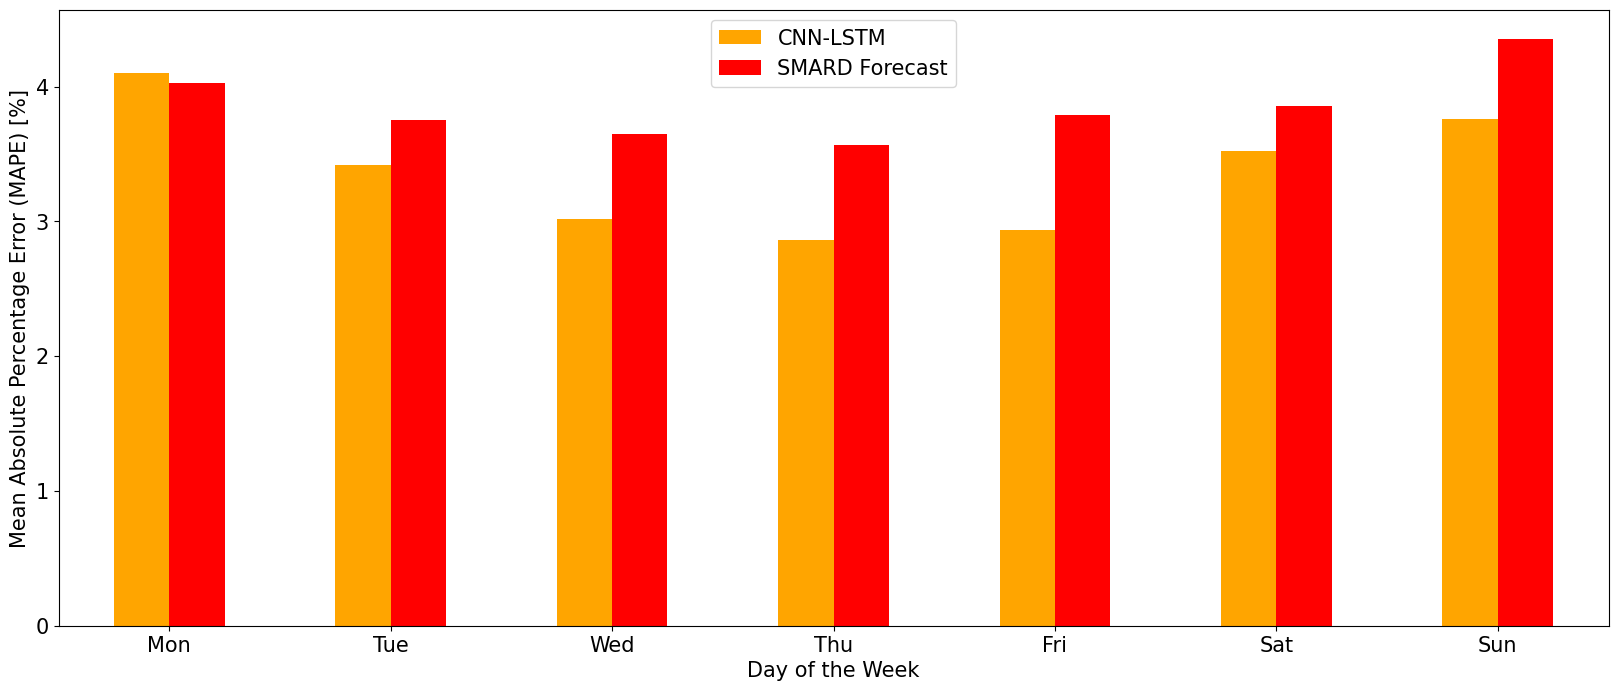

In [ ]:
results["Weekday"] = results['Date'].dt.day_name().str.slice(0, 3)
order_days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
results['Weekday'] = pd.Categorical(results['Weekday'], categories=order_days, ordered=True)

weekday_mean_model_APE = results.groupby(['Weekday'], observed=True)["Model Absolute Percentage Error"].mean()
weekday_mean_SMARD_APE = results.groupby(['Weekday'], observed=True)["SMARD Absolute Percentage Error"].mean()

mape_data = pd.DataFrame({
    'Weekday': order_days,
    'CNN-LSTM': weekday_mean_model_APE,
    'SMARD Forecast': weekday_mean_SMARD_APE
})


mape_data.plot(kind='bar', figsize=(20, 8), color=["orange","red","blue"])

plt.xlabel('Day of the Week', fontsize = 15)
plt.ylabel('Mean Absolute Percentage Error (MAPE) [%]', fontsize = 15)
plt.xticks(rotation=0, fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

plt.show()

### Barplot Months

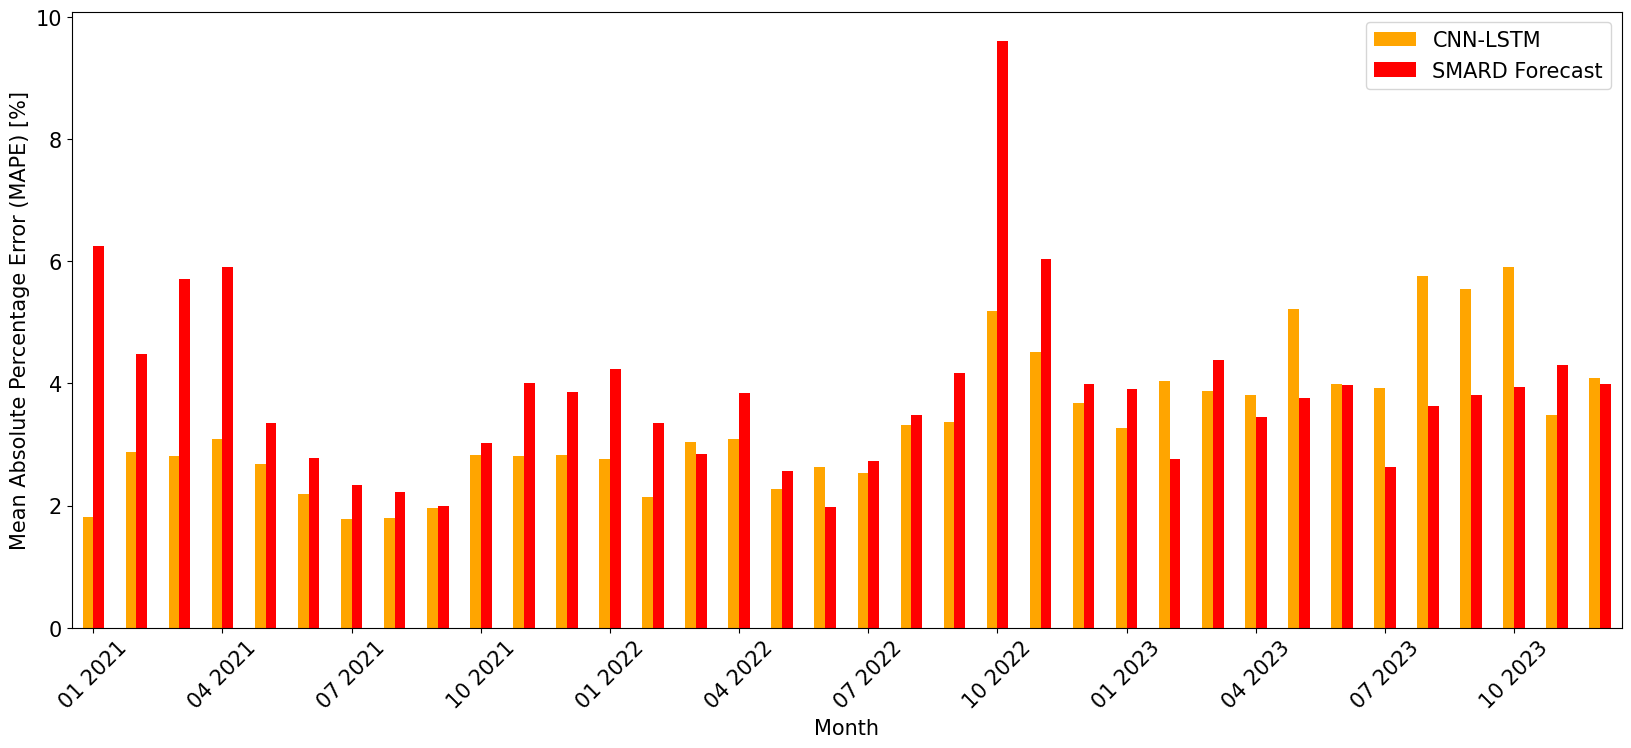

In [ ]:
results['Year Month'] = results['Date'].dt.strftime('%m %Y')

order_year_month = ["01 2021", "02 2021", "03 2021", "04 2021", "05 2021", "06 2021", "07 2021", "08 2021", "09 2021", "10 2021", "11 2021", "12 2021",
                        "01 2022", "02 2022", "03 2022", "04 2022", "05 2022", "06 2022", "07 2022", "08 2022", "09 2022", "10 2022", "11 2022", "12 2022",
                        "01 2023", "02 2023", "03 2023", "04 2023", "05 2023", "06 2023", "07 2023", "08 2023", "09 2023", "10 2023", "11 2023", "12 2023",]

results["Year Month"] = pd.Categorical(results["Year Month"], categories=order_year_month, ordered=True)

monthly_mean_model_APE = results.groupby(['Year Month'], observed=True)["Model Absolute Percentage Error"].mean()
monthly_mean_SMARD_APE = results.groupby(['Year Month'], observed=True)["SMARD Absolute Percentage Error"].mean()

mape_data = pd.DataFrame({
    'Year Month': order_year_month,
    'CNN-LSTM': monthly_mean_model_APE,
    'SMARD Forecast': monthly_mean_SMARD_APE
})

mape_data.plot(kind='bar', figsize=(20, 8), color=["orange","red","blue"])

plt.xlabel('Month', fontsize = 15)
plt.ylabel('Mean Absolute Percentage Error (MAPE) [%]', fontsize = 15)
plt.xticks(range(0, len(mape_data), 3), rotation=45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

plt.show()

### Forecasting Example during Public Holidays

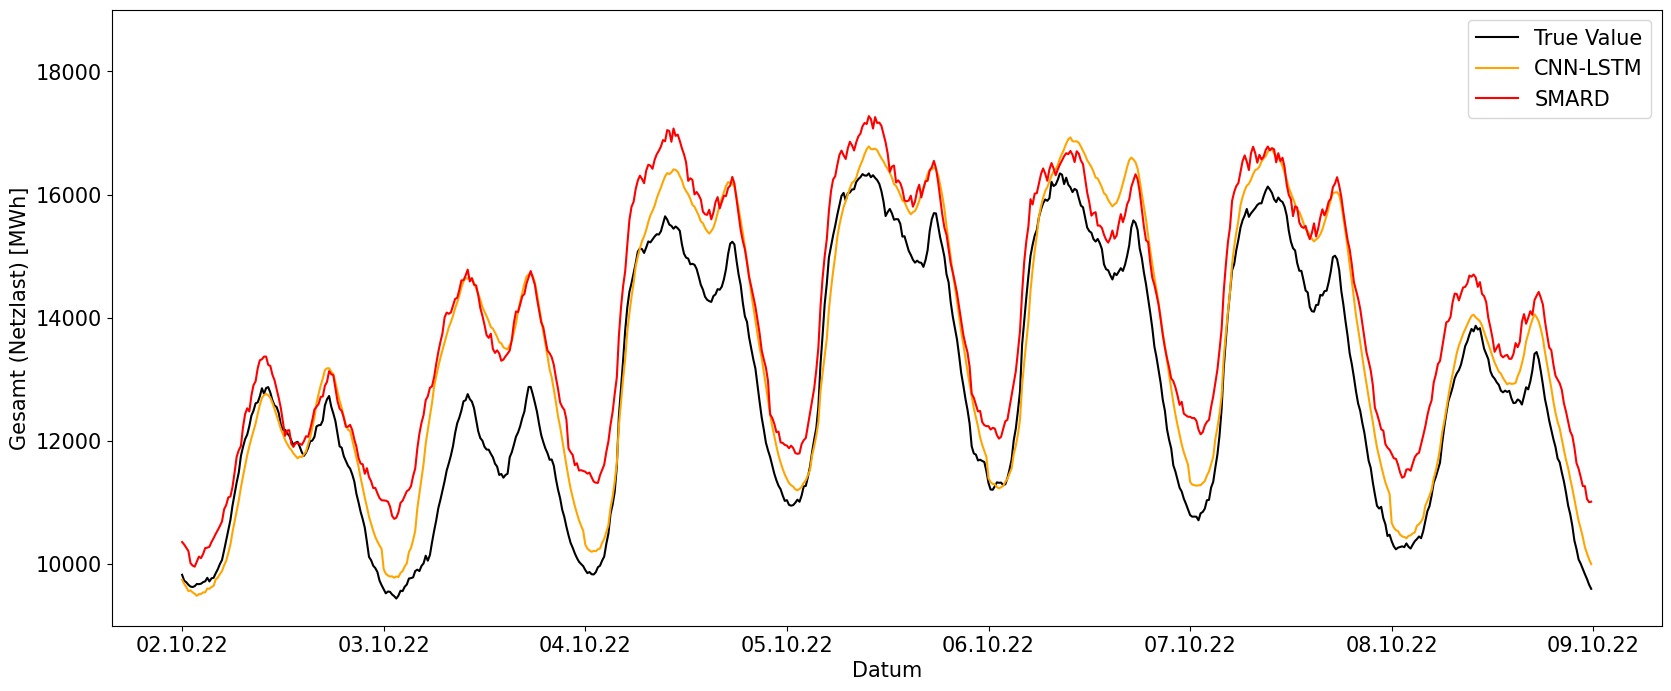

In [ ]:
fig1 = plt.figure(figsize=(20, 8))

results['Year Month Day'] = results['Date'].dt.strftime('%Y %m %d')

week_data = results[results['Year Month Day'].between('2022 10 02', '2022 10 08')]

plt.plot(week_data['Date'], week_data['True Value'], color='black', label='True Value')
plt.plot(week_data['Date'], week_data['Model Forecast'], color='orange', label='CNN-LSTM')
plt.plot(week_data['Date'], week_data['SMARD Forecast'], color='red', label='SMARD')
plt.xlabel('Datum', fontsize = 15)
plt.ylabel('Gesamt (Netzlast) [MWh]', fontsize = 15)
plt.ylim(9000, 19000)
plt.tick_params(axis='both', labelsize = 15)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
plt.legend(fontsize = 15, loc='upper right')
plt.show()

### Heatmap Day of Week - Time of Day

/tmp/ipykernel_1971/4230739017.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = results.pivot_table(index='Weekday', columns='Time', values="Comp", aggfunc="mean")


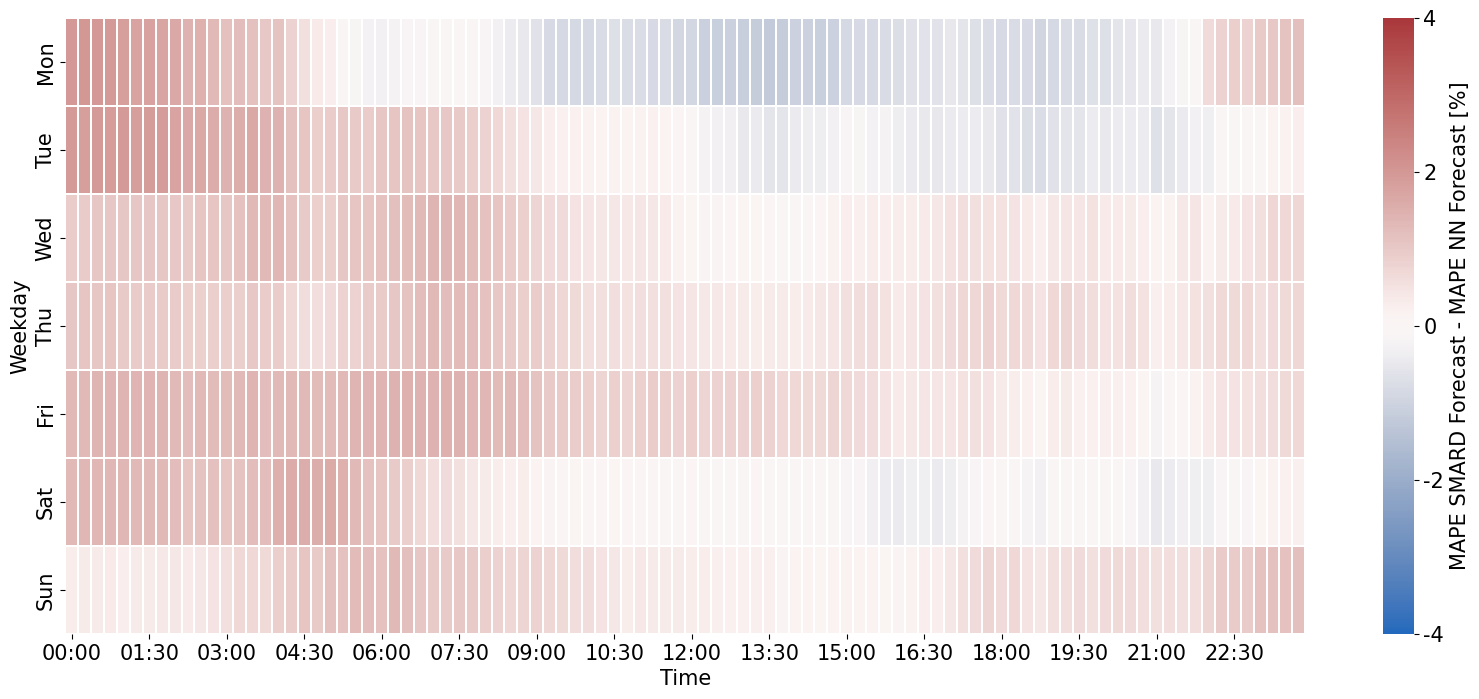

In [ ]:

results["Comp"] = results["SMARD Absolute Percentage Error"] - results["Model Absolute Percentage Error"]

results["Weekday"] = results['Date'].dt.day_name().str.slice(0, 3)
order_days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
results['Weekday'] = pd.Categorical(results['Weekday'], categories=order_days, ordered=True)

results['Time'] = results['Date'].dt.strftime("%H:%M")

heatmap_data = results.pivot_table(index='Weekday', columns='Time', values="Comp", aggfunc="mean")
    
divnorm = TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)

plt.figure(figsize=(20, 8))
ax = sns.heatmap(heatmap_data, cmap="vlag", norm=divnorm, annot=False, linewidths=.2, cbar=False, xticklabels=6)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel('Weekday', fontsize = 15)

cbar = plt.colorbar(ax.collections[0])   
cbar.outline.set_visible(False)
cbar.set_label('MAPE SMARD Forecast - MAPE NN Forecast [%]', fontsize=15)
cbar.set_ticks([-4, -2, 0, 2, 4])
cbar.set_ticklabels(['-4', '-2', '0', '2', '4'], fontsize=15)
    
plt.show()  

### Heatmap Months - Days

/tmp/ipykernel_1971/3824742947.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = results.pivot_table(index='Year Month', columns='Day', values="Comp", aggfunc="mean")


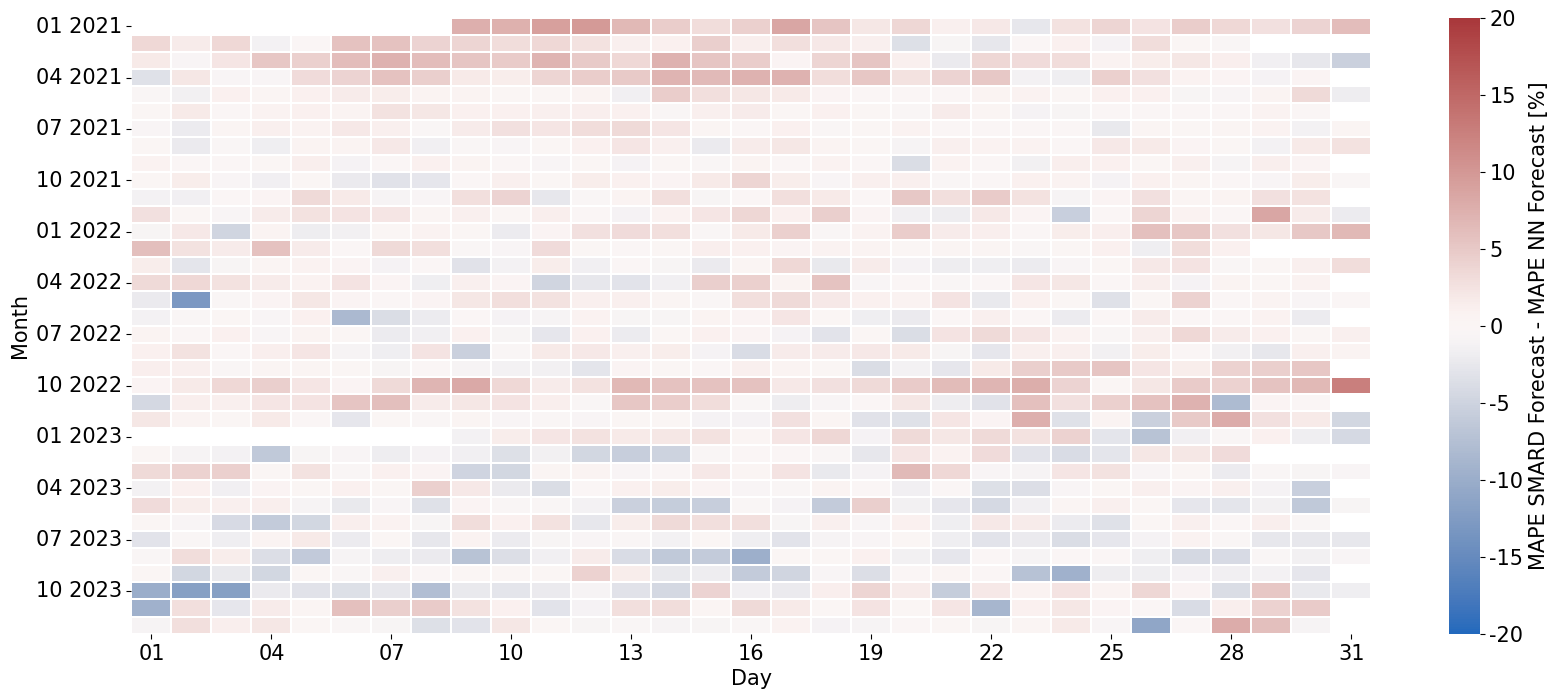

In [ ]:
results['Day'] = results['Date'].dt.strftime('%d')

heatmap_data = results.pivot_table(index='Year Month', columns='Day', values="Comp", aggfunc="mean")
divnorm = TwoSlopeNorm(vmin=-20, vcenter=0, vmax=20)

plt.figure(figsize=(20, 8))
ax = sns.heatmap(heatmap_data, cmap="vlag", norm=divnorm, annot=False, linewidths=.2, cbar=False, xticklabels=3, yticklabels=3)

ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('Day', fontsize = 15)
ax.set_ylabel('Month', fontsize = 15)

cbar = plt.colorbar(ax.collections[0])
cbar.outline.set_visible(False)
cbar.set_label('MAPE SMARD Forecast - MAPE NN Forecast [%]', fontsize=15)
cbar.set_ticks([-20, -15, -10, -5, 0, 5, 10, 15, 20])
cbar.set_ticklabels(['-20', '-15', '-10', '-5', '0', '5', '10', '15', '20'], fontsize=15)

plt.show()